# REST Timeseries QC (NSD)

This notebook loads example resting-state timeseries runs and plots:
- run inventory (session/run structure)
- global signal timecourse
- DVARS timecourse
- spatial snapshots (middle axial slice)

Default directory is set to your current server path.

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

In [2]:
# Change this if you want a different subject.
TIMESERIES_DIR = Path("/home/rothermm/resting_prediction/nsddata_timeseries/ppdata/subj01/func1pt8mm/timeseries")
MAX_EXAMPLE_RUNS = 6
RANDOM_SEED = 42

assert TIMESERIES_DIR.exists(), f"Directory not found: {TIMESERIES_DIR}"

In [3]:
pattern = re.compile(r"timeseries_session(\d+)_run(\d+)\.nii\.gz$")
files = sorted(
    p for p in TIMESERIES_DIR.glob("timeseries_session*_run*.nii.gz")
    if pattern.match(p.name)
)

entries = []
for p in files:
    m = pattern.match(p.name)
    entries.append({
        "path": p,
        "session": int(m.group(1)),
        "run": int(m.group(2)),
    })

print(f"Found {len(entries)} timeseries files")
print(f"Sessions: {sorted({e['session'] for e in entries})}")
print(f"Runs: {sorted({e['run'] for e in entries})}")
print("\nFirst 10 files:")
for e in entries[:10]:
    print(f"  session {e['session']:02d}, run {e['run']:02d}: {e['path'].name}")

Found 36 timeseries files
Sessions: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Runs: [1, 14]

First 10 files:
  session 21, run 01: timeseries_session21_run01.nii.gz
  session 21, run 14: timeseries_session21_run14.nii.gz
  session 22, run 01: timeseries_session22_run01.nii.gz
  session 22, run 14: timeseries_session22_run14.nii.gz
  session 23, run 01: timeseries_session23_run01.nii.gz
  session 23, run 14: timeseries_session23_run14.nii.gz
  session 24, run 01: timeseries_session24_run01.nii.gz
  session 24, run 14: timeseries_session24_run14.nii.gz
  session 25, run 01: timeseries_session25_run01.nii.gz
  session 25, run 14: timeseries_session25_run14.nii.gz


In [4]:
sessions = sorted({e["session"] for e in entries})
target_sessions = [sessions[0], sessions[len(sessions)//2], sessions[-1]] if sessions else []
target_runs = [1, 14]

example_entries = [
    e for e in entries
    if e["session"] in target_sessions and e["run"] in target_runs
]

if not example_entries:
    rng = np.random.default_rng(RANDOM_SEED)
    idx = rng.choice(len(entries), size=min(MAX_EXAMPLE_RUNS, len(entries)), replace=False)
    example_entries = [entries[i] for i in sorted(idx)]

print(f"Selected {len(example_entries)} example runs:")
for e in example_entries:
    print(f"  session {e['session']:02d}, run {e['run']:02d}: {e['path'].name}")

Selected 6 example runs:
  session 21, run 01: timeseries_session21_run01.nii.gz
  session 21, run 14: timeseries_session21_run14.nii.gz
  session 30, run 01: timeseries_session30_run01.nii.gz
  session 30, run 14: timeseries_session30_run14.nii.gz
  session 38, run 01: timeseries_session38_run01.nii.gz
  session 38, run 14: timeseries_session38_run14.nii.gz


In [5]:
def load_4d(path: Path):
    img = nib.load(str(path))
    data = img.get_fdata(dtype=np.float32)
    tr = float(img.header.get_zooms()[3]) if len(img.header.get_zooms()) >= 4 else np.nan
    return data, tr

def global_signal(data: np.ndarray):
    return data.mean(axis=(0, 1, 2))

def dvars(data: np.ndarray):
    diff = np.diff(data, axis=3)
    return np.sqrt(np.mean(diff**2, axis=(0, 1, 2)))

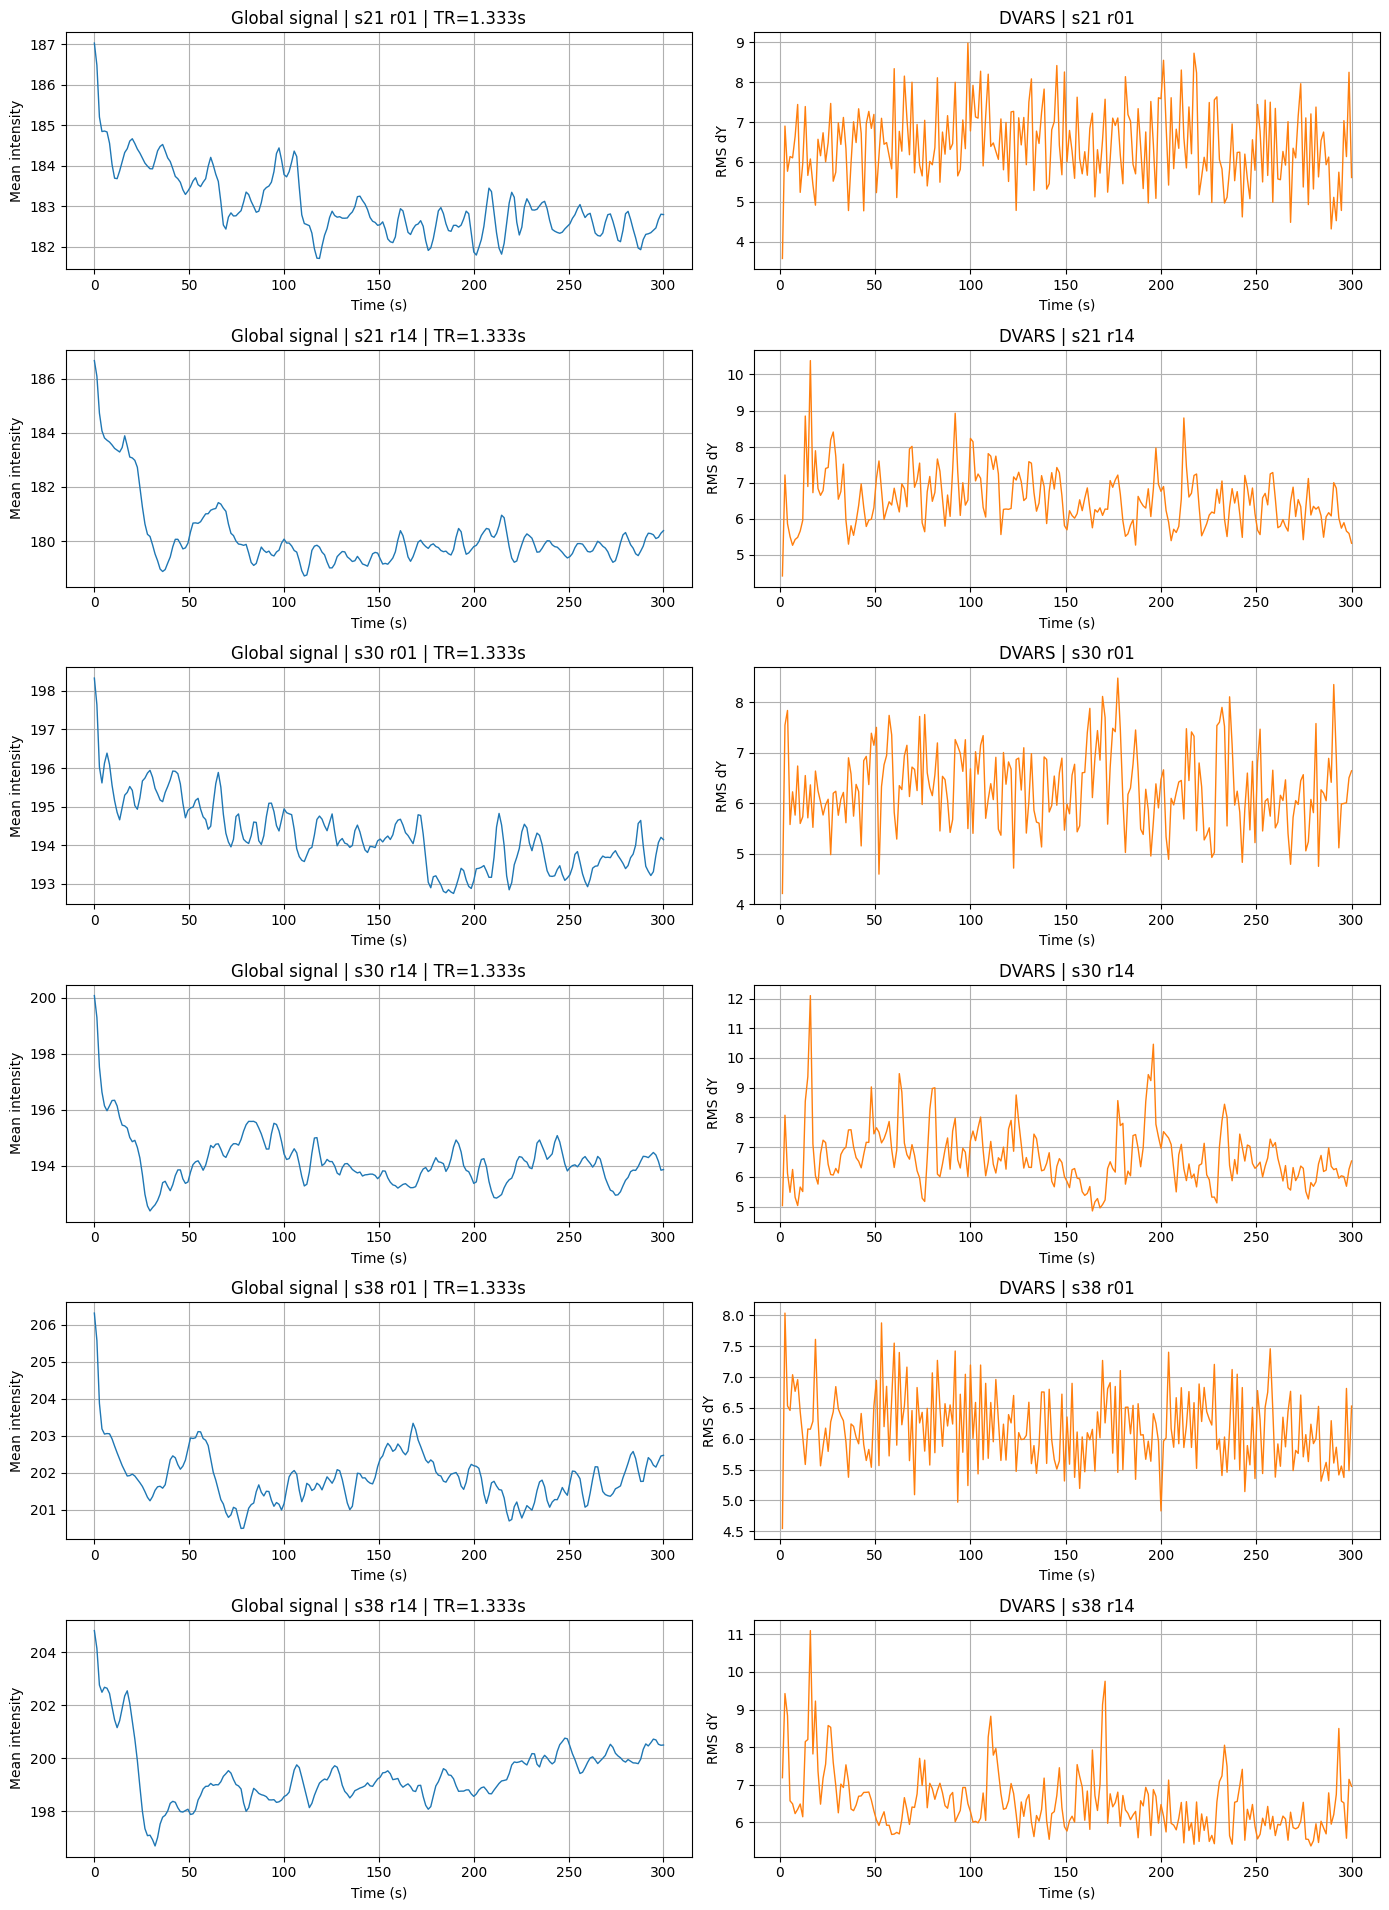

In [6]:
fig, axes = plt.subplots(len(example_entries), 2, figsize=(14, 3.2 * len(example_entries)), squeeze=False)

for i, e in enumerate(example_entries):
    data, tr = load_4d(e["path"])
    gs = global_signal(data)
    dv = dvars(data)

    t_gs = np.arange(gs.size) * tr
    t_dv = np.arange(1, gs.size) * tr

    axes[i, 0].plot(t_gs, gs, lw=1.0)
    axes[i, 0].set_title(f"Global signal | s{e['session']:02d} r{e['run']:02d} | TR={tr:.3f}s")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Mean intensity")

    axes[i, 1].plot(t_dv, dv, lw=1.0, color="tab:orange")
    axes[i, 1].set_title(f"DVARS | s{e['session']:02d} r{e['run']:02d}")
    axes[i, 1].set_xlabel("Time (s)")
    axes[i, 1].set_ylabel("RMS dY")

plt.tight_layout()
plt.show()

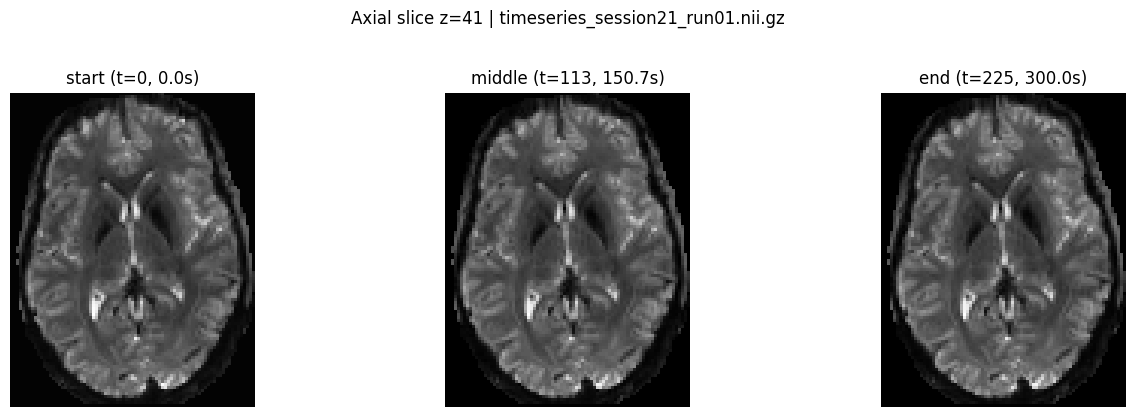

In [7]:
# Spatial snapshots for one representative run.
entry = example_entries[0]
data, tr = load_4d(entry["path"])

z = data.shape[2] // 2
time_idx = [0, data.shape[3] // 2, data.shape[3] - 1]
labels = ["start", "middle", "end"]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for ax, ti, lbl in zip(axs, time_idx, labels):
    im = data[:, :, z, ti].T
    ax.imshow(im, cmap="gray", origin="lower")
    ax.set_title(f"{lbl} (t={ti}, {ti*tr:.1f}s)")
    ax.axis("off")

fig.suptitle(f"Axial slice z={z} | {entry['path'].name}", y=1.03)
plt.tight_layout()
plt.show()

n_files: 36
n_volumes (min/median/max): 226 226 226
TR unique: [np.float64(1.333333)]


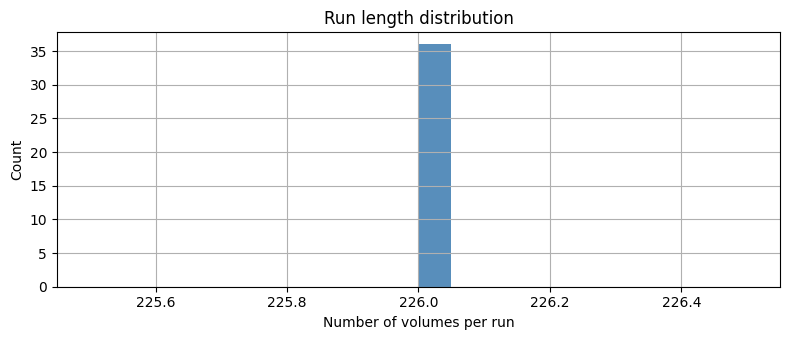

In [8]:
# Lightweight inventory summary (header-only; does not read full arrays).
summary = []
for e in entries:
    img = nib.load(str(e["path"]))
    shape = img.shape
    tr = float(img.header.get_zooms()[3]) if len(img.header.get_zooms()) >= 4 else np.nan
    summary.append((e["session"], e["run"], shape[3], tr))

summary = np.array(summary, dtype=float)
print("n_files:", summary.shape[0])
print("n_volumes (min/median/max):", int(summary[:, 2].min()), int(np.median(summary[:, 2])), int(summary[:, 2].max()))
print("TR unique:", sorted(set(summary[:, 3].round(6))))

plt.figure(figsize=(8, 3.5))
plt.hist(summary[:, 2], bins=20, color="steelblue", alpha=0.9)
plt.xlabel("Number of volumes per run")
plt.ylabel("Count")
plt.title("Run length distribution")
plt.tight_layout()
plt.show()